In [3]:
!pip install m3_learning --no-deps
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.8/47.8 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 7.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 56.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 51.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 97.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 60.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 96.9 MB/s eta 0:00:00
   ━━━

In [4]:
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch
import os
from torch.utils.data import Dataset, DataLoader
import time

from m3_learning.nn.time_series_nn.nn_util import Train, transform_nn
from m3_learning.util.rand_util import rand_tensor
from m3_learning.viz.style import set_style
from m3_learning.nn.random import random_seed
set_style("printing")
random_seed(seed=42)

Pytorch seed was set to 42
Numpy seed was set to 42


2024-07-19 00:27:34.446986: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-19 00:27:34.466105: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-19 00:27:34.483068: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-19 00:27:34.488068: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-19 00:27:34.502513: I tensorflow/core/platform/cpu_feature_guar

tensorflow seed was set to 42


In [6]:
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")

In [7]:
class Linear_func:
    def __init__(self, x, slope=[0,1], b=[0,1], size=(1,1),batch_size=100, verbose=False):
        self.x = x

        self.slope = slope
        self.slope_mean = torch.tensor(slope[0] + slope[1]) / 2
        self.slope_sd = torch.sqrt(torch.pow(torch.tensor(slope[1]) - torch.tensor(slope[0]), 2) / 12)
        
        self.b = b
        self.b_mean = torch.tensor(b[0] + b[1]) / 2
        self.b_sd = torch.sqrt(torch.pow(torch.tensor(b[1]) - torch.tensor(b[0]), 2) / 12)
        
        self.size = size
        self.batch_size = batch_size
        self.verbose = verbose

    def compute(self, params, device='cuda'):
        if len(params.size()) == 2:
            params = torch.reshape(params, (params.shape[0], 3, -1))

        out = torch.zeros(
            (params.shape[0], self.x.shape[0],
             self.size[0], self.size[1])
        )

        params = params.to(device)

        for i in range(self.size[1]):

            if params.ndim == 4:
                _slope = params[:, 0, 0, i]
                _b = params[:, 0, 1, i]

            if params.ndim == 3:
                _slope = params[:, 0, i]
                _b = params[:, 1, i]

            x = (
                torch.cat(params.shape[0] * [self.x])
                .reshape(params.shape[0], -1)
                .to(device)
            )
            x = torch.transpose(x, 0, 1)  # .to(device)

            _out = _slope * x + _b

            out[:, :, 0, i] = torch.transpose(_out, 0, 1)

        return (torch.sum(out, dim=3), out)
    
    def sampler(self, device='cuda'):
        slope = rand_tensor(
            min=self.slope[0],
            max=self.slope[1],
            size=(self.batch_size, self.size[0], self.size[1]),
        )

        b = rand_tensor(
            min=self.b[0],
            max=self.b[1],
            size=(self.batch_size, self.size[0], self.size[1]),
        )

        _params = torch.torch.stack((slope, b))
        _params = torch.atleast_2d(_params)
        _params = torch.transpose(_params, 0, 1)
        _params = torch.transpose(_params, 1, 2)
        
        return (self.compute(_params, device=device), _params)

In [39]:
constructor = Linear_func(x=torch.linspace(0, np.pi, 100), slope=[-10,10], b=[-10,10])
output = constructor.sampler()
spectra, params = output
spectra_full, spectras = spectra

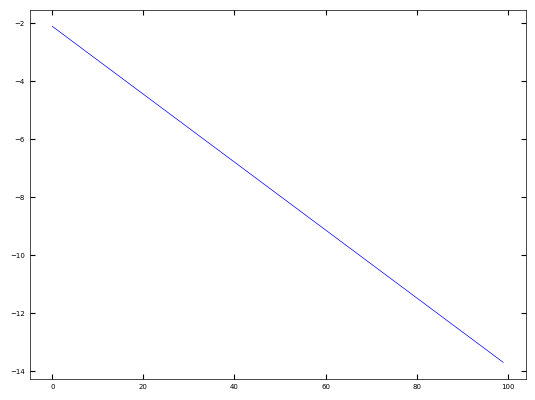

In [40]:
rand = np.random.randint(0, 100)
plt.plot(spectras[rand, :, 0].cpu(), "b")

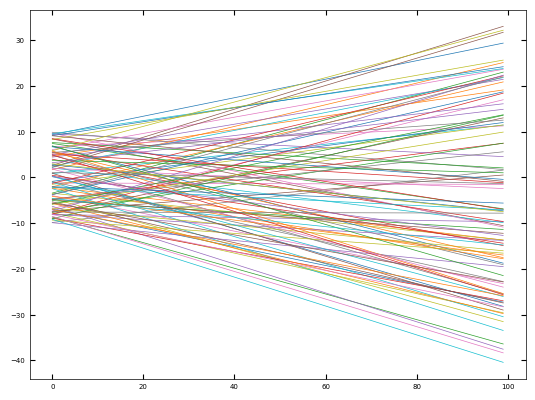

In [41]:
for i in range(100):
    plt.plot(spectras[i, :, 0].cpu(), "-")